Let's search the [Coastwatch ERDDAP](https://coastwatch.pfeg.noaa.gov/erddap/index.html) for datasets that contain the following information:

```
sanctsound "Sound Production"
```

In [1]:
from erddapy import ERDDAP
import pandas as pd

server = "https://coastwatch.pfeg.noaa.gov/erddap/"

protocol = "griddap"

search_for = 'sanctsound "Sound Production"'

e = ERDDAP(server=server, protocol=protocol)

url = e.get_search_url(search_for=search_for, response="csv")

datasets = pd.read_csv(url)[["Dataset ID","Title"]]

datasets

,Dataset ID,Title
0,noaaSanctSound_GR01_01_dolphins_1h,NOAA-Navy Sanctuary Soundscape Monitoring Proj...
1,noaaSanctSound_GR01_02_dolphins_1h,NOAA-Navy Sanctuary Soundscape Monitoring Proj...
2,noaaSanctSound_GR01_03_dolphins_1h,NOAA-Navy Sanctuary Soundscape Monitoring Proj...
3,noaaSanctSound_GR01_04_dolphins_1h,NOAA-Navy Sanctuary Soundscape Monitoring Proj...
4,noaaSanctSound_GR01_05_dolphins_1h,NOAA-Navy Sanctuary Soundscape Monitoring Proj...
...,...,...
690,noaaSanctSound_SB03_08_finwhale_1d,NOAA-Navy Sanctuary Soundscape Monitoring Proj...
691,noaaSanctSound_SB03_09_finwhale_1d,NOAA-Navy Sanctuary Soundscape Monitoring Proj...
692,noaaSanctSound_SB03_10_finwhale_1d,NOAA-Navy Sanctuary Soundscape Monitoring Proj...
693,noaaSanctSound_SB03_11_finwhale_1d,NOAA-Navy Sanctuary Soundscape Monitoring Proj...


WoRMS lookup (which we don't need because Abby created a mapping table which we will use below)

In [2]:
# import pyworms

# title_piece = datasets.Title.str.split(",",expand=True)

# # pull out animal info from title

# title_unique = title_piece[1].str.replace(" Sound Production","").str.replace(" Sound Producion","").unique()

# animals = title_unique.tolist()

# animals_clean = []

# for animal in animals:
    
#     clean_str = animal.lstrip().lower()
    
#     animals_clean.append(clean_str)
    
#     print('Searching WoRMS for {}\n'.format(clean_str))
    
#     match = pyworms.aphiaRecordsByMatchNames(clean_str)
    
#     if match[0]:
#         print('Found {}:\n{}\n'.format(clean_str,match))
#     else:
#         print('{} not found\n'.format(clean_str))

Looks like we need to create a lookup table ourselves!

term | WoRMS Map 
-----|------
`dolphin` |
`blue whale` |
`bocaccio` |
`fin whale` |
`pinniped` |
`red grouper` |
`sei whale` |
`atlantic cod` |
`black grouper` |
`humpback whale` |
`killer whale` |
`minke whale` |
`plainfin midshipman` |
`north atlantic right whale` |

Instead of searching WoRMS, we will use the mapping table Abby created.

In [3]:
import pandas as pd

df_mapping = pd.read_csv('SanctSound_SpeciesLookupTable.csv')

df_mapping

,vernacularName,scientificName,scientificNameID,taxonRank,kingdom
0,dolphin,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
1,blue whale,Balaenoptera musculus,urn:lsid:marinespecies.org:taxname:137090,Species,Animalia
2,bocaccio,Sebastes paucispinis,urn:lsid:marinespecies.org:taxname:274833,Species,Animalia
3,fin whale,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia
4,pinniped,Pinnipedia,urn:lsid:marinespecies.org:taxname:148736),Infraorder,Animalia
5,red grouper,Epinephelus morio,urn:lsid:marinespecies.org:taxname:159354,Species,Animalia
6,sei whale,Balaenoptera borealis,urn:lsid:marinespecies.org:taxname:137088,Species,Animalia
7,atlantic cod,Gadus morhua,urn:lsid:marinespecies.org:taxname:126436,Species,Animalia
8,black grouper,Mycteroperca bonaci,urn:lsid:marinespecies.org:taxname:159231,Species,Animalia
9,humpback whale,Megaptera novaeangliae,urn:lsid:marinespecies.org:taxname:137092,Species,Animalia


# Read the dataset as netCDF data.

First let's do it for one dataset

In [4]:
e.dataset_id = datasets['Dataset ID'][0]

ds = e.to_xarray()

ds

<xarray.Dataset>
Dimensions:           (start_time: 3185)
Coordinates:
  * start_time        (start_time) datetime64[ns] 2018-12-14T21:00:00 ... 201...
Data variables:
    dolphin_presence  (start_time) float64 ...
    end_time          (start_time) datetime64[ns] ...
Attributes: (12/33)
    abstract:                  This record represents dolphin whistle and moa...
    acknowledgement:           This project received funding from the U.S. Navy.
    cdm_data_type:             TimeSeries
    citation:                  Cite as: NOAA Office of National Marine Sanctu...
    comment:                   Data quality: Quality data were recorded for t...
    contributor_name:          Simone Baumann-Pickering, Scripps Institution ...
    ...                        ...
    publisher_type:            institution
    publisher_url:             https://www.pfeg.noaa.gov
    sourceUrl:                 (local files)
    standard_name_vocabulary:  CF Standard Name Table v55
    summary:                   NOAA and the U.S. Navy are working to better u...
    title:                     NOAA-Navy Sanctuary Soundscape Monitoring Proj...

Where are these data observed at?

In [5]:
print(ds.geospatial_bounds)

POINT (31.396417 -80.8904)


Now lets find the `start_time` and `end_time` when dolphins were present in this dataset (`dolphin_presence == 1`).

To do this we look through the variables in the dataset to find the data variable which ends with the phrase `presence`. This will return the string of the variable name `dolphin_presence`. Then, we want to filter the dataset for when that variable has values equal to 1.0 (or present). Then, we drop any entrys not equal to 1.0.

This returns a filtered xarray dataset of only presence values along with `start_time`, `end_time`, and all the associated metadata.

In [6]:
var = [var for var in ds.data_vars if var.endswith("presence")][0]

time_var = list(ds.coords)[0]

ds_subset = ds.where(ds[var] == 1.0).dropna(time_var, how="any")

ds_subset

<xarray.Dataset>
Dimensions:           (start_time: 191)
Coordinates:
  * start_time        (start_time) datetime64[ns] 2018-12-15T04:00:00 ... 201...
Data variables:
    dolphin_presence  (start_time) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    end_time          (start_time) datetime64[ns] 2018-12-15T05:00:00 ... 201...
Attributes: (12/33)
    abstract:                  This record represents dolphin whistle and moa...
    acknowledgement:           This project received funding from the U.S. Navy.
    cdm_data_type:             TimeSeries
    citation:                  Cite as: NOAA Office of National Marine Sanctu...
    comment:                   Data quality: Quality data were recorded for t...
    contributor_name:          Simone Baumann-Pickering, Scripps Institution ...
    ...                        ...
    publisher_type:            institution
    publisher_url:             https://www.pfeg.noaa.gov
    sourceUrl:                 (local files)
    standard_name_vocabulary:  CF Standard Name Table v55
    summary:                   NOAA and the U.S. Navy are working to better u...
    title:                     NOAA-Navy Sanctuary Soundscape Monitoring Proj...

We can now start porting that information into the DarwinCore format as a Pandas DataFrame.

In [7]:
df = ds_subset.to_dataframe().reset_index()

df['WKT'] = ds.geospatial_bounds

df['decimalLatitude'] = ds.geospatial_bounds.split(" ")[1].replace("(","")

df['deimalLongitude'] = ds.geospatial_bounds.split(" ")[2].replace(")","")

df['vernacularName'] = ds.title.split(",")[1].replace(" Sound Production","").replace(" Sound Producion","").lower().lstrip()

df.head()

,start_time,dolphin_presence,end_time,WKT,decimalLatitude,deimalLongitude,vernacularName
0,2018-12-15 04:00:00,1.0,2018-12-15 05:00:00,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin
1,2018-12-15 05:00:00,1.0,2018-12-15 06:00:00,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin
2,2018-12-15 06:00:00,1.0,2018-12-15 07:00:00,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin
3,2018-12-15 07:00:00,1.0,2018-12-15 08:00:00,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin
4,2018-12-15 18:00:00,1.0,2018-12-15 19:00:00,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin


Now we can add in the information from our WoRMS mapping above.

In [8]:
df_occur = pd.merge(df, df_mapping, how='left', on='vernacularName')

df_occur

,start_time,dolphin_presence,end_time,WKT,decimalLatitude,deimalLongitude,vernacularName,scientificName,scientificNameID,taxonRank,kingdom
0,2018-12-15 04:00:00,1.0,2018-12-15 05:00:00,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
1,2018-12-15 05:00:00,1.0,2018-12-15 06:00:00,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
2,2018-12-15 06:00:00,1.0,2018-12-15 07:00:00,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
3,2018-12-15 07:00:00,1.0,2018-12-15 08:00:00,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
4,2018-12-15 18:00:00,1.0,2018-12-15 19:00:00,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
...,...,...,...,...,...,...,...,...,...,...,...
186,2019-04-13 07:00:00,1.0,2019-04-13 08:00:00,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
187,2019-04-14 04:00:00,1.0,2019-04-14 05:00:00,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
188,2019-04-18 12:00:00,1.0,2019-04-18 13:00:00,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
189,2019-04-24 05:00:00,1.0,2019-04-24 06:00:00,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia


# Next let's do it for all of them.

In [9]:
#%%timeit 

e.response = "nc"

df_final = pd.DataFrame()

for index, row in datasets.iterrows():
    
    print('\n{}/{} datasets\n'.format(index+1,datasets.shape[0]))
    print('querying {}'.format(row['Dataset ID']))
    
    e.dataset_id = row['Dataset ID']
    
    # set up try/except to skip datasets that we cant pull into xarray - issues with configuration
    try:
        ds = e.to_xarray()
    except:
        print('Skipping {} - url not functioning'.format(row['Dataset ID']))
        continue
    
    time_var = list(ds.coords)[0]
    
    print('{} ({} rows): {}'.format(row['Dataset ID'],ds.coords.dims[time_var],ds.geospatial_bounds))
    
    # set up try/except to test for presence vars, skip datasets without them.
    try:
        var = [var for var in ds.data_vars if var.endswith("presence")][0]
    except:
        print('Skipping {} - no presence vars'.format(row['Dataset ID']))
        continue

    ds_subset = ds.where(ds[var] == 1.0).dropna(time_var, how="any")
    
    # TODO kick out if ds_subset is empty
    if ds_subset.coords.dims[time_var] == 0:
        print('{} obs - moving to next dataset'.format(ds_subset.coords.dims[time_var]))
        continue
        
    df = ds_subset.to_dataframe().reset_index()
    
    print('Subsetted to ({} rows)'.format(ds_subset.coords.dims[time_var]))
    
    df['dataset_id'] = row['Dataset ID']

    df['WKT'] = ds.geospatial_bounds

    df['decimalLatitude'] = ds.geospatial_bounds.split(" ")[1].replace("(","")

    df['decimalLongitude'] = ds.geospatial_bounds.split(" ")[2].replace(")","")

    df['vernacularName'] = ds.title.split(",")[1].replace(" Sound Production","").replace(" Sound Producion","").lower().lstrip()
    
    df_final = pd.concat([df_final, df])

# write to csv file
#df_occur.to_csv('data/sanctsound_presence.csv', index=False)


1/695 datasets

querying noaaSanctSound_GR01_01_dolphins_1h
noaaSanctSound_GR01_01_dolphins_1h (3185 rows): POINT (31.396417 -80.8904)
Subsetted to (191 rows)

2/695 datasets

querying noaaSanctSound_GR01_02_dolphins_1h
noaaSanctSound_GR01_02_dolphins_1h (3029 rows): POINT (31.396417 -80.8904)
Subsetted to (56 rows)

3/695 datasets

querying noaaSanctSound_GR01_03_dolphins_1h
noaaSanctSound_GR01_03_dolphins_1h (2532 rows): POINT (31.396417 -80.8904)
Subsetted to (146 rows)

4/695 datasets

querying noaaSanctSound_GR01_04_dolphins_1h
noaaSanctSound_GR01_04_dolphins_1h (2693 rows): POINT (31.396417 -80.8904)
Subsetted to (110 rows)

5/695 datasets

querying noaaSanctSound_GR01_05_dolphins_1h
noaaSanctSound_GR01_05_dolphins_1h (3344 rows): POINT (31.396417 -80.8904)
Subsetted to (341 rows)

6/695 datasets

querying noaaSanctSound_GR02_02_dolphins_1h
noaaSanctSound_GR02_02_dolphins_1h (2741 rows): POINT (31.376133 -80.839133)
Subsetted to (291 rows)

7/695 datasets

querying noaaSanctSoun

noaaSanctSound_GR03_02_bluewhale_1d (131 rows): POINT (31.36749 -80.895)
0 obs - moving to next dataset

56/695 datasets

querying noaaSanctSound_MB01_01_bluewhale
noaaSanctSound_MB01_01_bluewhale (4260 rows): POINT (36.798 -121.976)
Subsetted to (4260 rows)

57/695 datasets

querying noaaSanctSound_MB01_02_bluewhale_manual
noaaSanctSound_MB01_02_bluewhale_manual (331 rows): POINT (36.798 -121.976)
Subsetted to (331 rows)

58/695 datasets

querying noaaSanctSound_MB01_03_bluewhale
noaaSanctSound_MB01_03_bluewhale (43418 rows): POINT (36.798 -121.976)
Subsetted to (43418 rows)

59/695 datasets

querying noaaSanctSound_MB01_04_bluewhale
noaaSanctSound_MB01_04_bluewhale (3587 rows): POINT (36.798 -121.976)
Subsetted to (3587 rows)

60/695 datasets

querying noaaSanctSound_MB01_05_bluewhale
noaaSanctSound_MB01_05_bluewhale (6034 rows): POINT (36.7977 -121.9757)
Subsetted to (6034 rows)

61/695 datasets

querying noaaSanctSound_MB01_06_bluewhale
noaaSanctSound_MB01_06_bluewhale (44236 rows)

noaaSanctSound_SB02_09_bluewhale_1d (67 rows): POINT (42.470708 -70.242457)
0 obs - moving to next dataset

112/695 datasets

querying noaaSanctSound_SB02_10_bluewhale_1d
Skipping noaaSanctSound_SB02_10_bluewhale_1d - url not functioning

113/695 datasets

querying noaaSanctSound_SB02_11_bluewhale_1d
Skipping noaaSanctSound_SB02_11_bluewhale_1d - url not functioning

114/695 datasets

querying noaaSanctSound_SB02_12_bluewhale_1d
noaaSanctSound_SB02_12_bluewhale_1d (67 rows): POINT (42.47083 -70.242287)
0 obs - moving to next dataset

115/695 datasets

querying noaaSanctSound_SB03_01_bluewhale_1d
noaaSanctSound_SB03_01_bluewhale_1d (78 rows): POINT (42.25541 -70.178607)
0 obs - moving to next dataset

116/695 datasets

querying noaaSanctSound_SB03_02_bluewhale_1d
Skipping noaaSanctSound_SB03_02_bluewhale_1d - url not functioning

117/695 datasets

querying noaaSanctSound_SB03_03_bluewhale_1d
Skipping noaaSanctSound_SB03_03_bluewhale_1d - url not functioning

118/695 datasets

querying n

noaaSanctSound_FK02_04_dolphins_1h (1795 rows): POINT (24.4888 -81.666316)
Subsetted to (20 rows)

166/695 datasets

querying noaaSanctSound_FK02_05_dolphins_1h
noaaSanctSound_FK02_05_dolphins_1h (986 rows): POINT (24.48896 -81.6664)
Subsetted to (28 rows)

167/695 datasets

querying noaaSanctSound_FK02_06_dolphins_1h
noaaSanctSound_FK02_06_dolphins_1h (2868 rows): POINT (24.48896 -81.6664)
Subsetted to (64 rows)

168/695 datasets

querying noaaSanctSound_FK03_01_dolphins_1h
noaaSanctSound_FK03_01_dolphins_1h (3037 rows): POINT (24.45895 -81.774133)
Subsetted to (222 rows)

169/695 datasets

querying noaaSanctSound_FK03_03_dolphins_1h
Skipping noaaSanctSound_FK03_03_dolphins_1h - url not functioning

170/695 datasets

querying noaaSanctSound_FK03_04_dolphins_1h
noaaSanctSound_FK03_04_dolphins_1h (660 rows): POINT (24.45895 -81.774133)
Subsetted to (18 rows)

171/695 datasets

querying noaaSanctSound_FK03_05_dolphins_1h
noaaSanctSound_FK03_05_dolphins_1h (795 rows): POINT (24.45895 -81.

noaaSanctSound_SB02_13_dolphins_1h (1559 rows): POINT (42.471128 -70.241957)
Subsetted to (359 rows)

217/695 datasets

querying noaaSanctSound_SB02_14_dolphins_1h
noaaSanctSound_SB02_14_dolphins_1h (1294 rows): POINT (42.471233 -70.24206)
Subsetted to (163 rows)

218/695 datasets

querying noaaSanctSound_SB02_15_dolphins_1h
noaaSanctSound_SB02_15_dolphins_1h (1604 rows): POINT (42.471452 -70.241883)
Subsetted to (894 rows)

219/695 datasets

querying noaaSanctSound_SB02_16_dolphins_1h
noaaSanctSound_SB02_16_dolphins_1h (1463 rows): POINT (42.47147 -70.24188)
Subsetted to (74 rows)

220/695 datasets

querying noaaSanctSound_SB02_17_dolphins_1h
noaaSanctSound_SB02_17_dolphins_1h (1439 rows): POINT (42.471435 -70.241828)
Subsetted to (284 rows)

221/695 datasets

querying noaaSanctSound_SB02_18_dolphins_1h
noaaSanctSound_SB02_18_dolphins_1h (1942 rows): POINT (42.47146 -70.2418)
Subsetted to (482 rows)

222/695 datasets

querying noaaSanctSound_SB03_01_dolphins_1h
noaaSanctSound_SB03_01_

noaaSanctSound_CI04_08_finwhale_1d (108 rows): POINT (33.8485 -120.1159)
Subsetted to (108 rows)

268/695 datasets

querying noaaSanctSound_CI05_01_finwhale_1d
noaaSanctSound_CI05_01_finwhale_1d (37 rows): POINT (34.0178 -119.3172)
Subsetted to (36 rows)

269/695 datasets

querying noaaSanctSound_CI05_02_finwhale_1d
noaaSanctSound_CI05_02_finwhale_1d (125 rows): POINT (34.0178 -119.3172)
Subsetted to (18 rows)

270/695 datasets

querying noaaSanctSound_CI05_03_finwhale_1d
noaaSanctSound_CI05_03_finwhale_1d (59 rows): POINT (34.0178 -119.317)
Subsetted to (43 rows)

271/695 datasets

querying noaaSanctSound_CI05_04_finwhale_1d
noaaSanctSound_CI05_04_finwhale_1d (139 rows): POINT (34.0178 -119.317)
Subsetted to (110 rows)

272/695 datasets

querying noaaSanctSound_CI05_05_finwhale_1d
Skipping noaaSanctSound_CI05_05_finwhale_1d - url not functioning

273/695 datasets

querying noaaSanctSound_CI05_06_finwhale_1d
noaaSanctSound_CI05_06_finwhale_1d (120 rows): POINT (34.0178 -119.3171)
Subse

noaaSanctSound_FK03_01_seiwhale_1d (128 rows): POINT (24.45895 -81.774133)
0 obs - moving to next dataset

319/695 datasets

querying noaaSanctSound_GR01_01_seiwhale_1d
noaaSanctSound_GR01_01_seiwhale_1d (140 rows): POINT (31.396417 -80.8904)
0 obs - moving to next dataset

320/695 datasets

querying noaaSanctSound_GR01_02_seiwhale_1d
noaaSanctSound_GR01_02_seiwhale_1d (143 rows): POINT (31.396417 -80.8904)
0 obs - moving to next dataset

321/695 datasets

querying noaaSanctSound_GR02_02_seiwhale_1d
noaaSanctSound_GR02_02_seiwhale_1d (134 rows): POINT (31.376133 -80.839133)
0 obs - moving to next dataset

322/695 datasets

querying noaaSanctSound_GR03_02_seiwhale_1d
noaaSanctSound_GR03_02_seiwhale_1d (131 rows): POINT (31.36749 -80.895)
0 obs - moving to next dataset

323/695 datasets

querying noaaSanctSound_SB01_01_seiwhale_1d
noaaSanctSound_SB01_01_seiwhale_1d (78 rows): POINT (42.436838 -70.546958)
0 obs - moving to next dataset

324/695 datasets

querying noaaSanctSound_SB01_02_se

noaaSanctSound_SB01_14_atlanticcod (1 rows): POINT (42.438323 -70.54551)
0 obs - moving to next dataset

371/695 datasets

querying noaaSanctSound_SB02_01_atlanticcod
noaaSanctSound_SB02_01_atlanticcod (133 rows): POINT (42.470793 -70.24294)
Subsetted to (133 rows)

372/695 datasets

querying noaaSanctSound_SB02_02_atlanticcod
noaaSanctSound_SB02_02_atlanticcod (3 rows): POINT (42.4708417 -70.24281)
Subsetted to (3 rows)

373/695 datasets

querying noaaSanctSound_SB02_03_atlanticcod
noaaSanctSound_SB02_03_atlanticcod (1 rows): POINT (42.4713583 -70.2427633)
0 obs - moving to next dataset

374/695 datasets

querying noaaSanctSound_SB02_04_atlanticcod
noaaSanctSound_SB02_04_atlanticcod (29 rows): POINT (42.4708617 -70.2424117)
Subsetted to (29 rows)

375/695 datasets

querying noaaSanctSound_SB02_05_atlanticcod
noaaSanctSound_SB02_05_atlanticcod (32 rows): POINT (42.4708733 -70.2423833)
Subsetted to (32 rows)

376/695 datasets

querying noaaSanctSound_SB02_06_atlanticcod
noaaSanctSound_S

noaaSanctSound_CI05_03_humpbackwhale_1d (59 rows): POINT (34.0178 -119.317)
Subsetted to (15 rows)

421/695 datasets

querying noaaSanctSound_CI05_04_humpbackwhale_1d
noaaSanctSound_CI05_04_humpbackwhale_1d (139 rows): POINT (34.0178 -119.317)
Subsetted to (78 rows)

422/695 datasets

querying noaaSanctSound_CI05_05_humpbackwhale_1d
noaaSanctSound_CI05_05_humpbackwhale_1d (9 rows): POINT (34.01785 -119.3171)
Subsetted to (2 rows)

423/695 datasets

querying noaaSanctSound_CI05_06_humpbackwhale_1d
noaaSanctSound_CI05_06_humpbackwhale_1d (120 rows): POINT (34.0178 -119.3171)
Subsetted to (67 rows)

424/695 datasets

querying noaaSanctSound_CI05_08_humpbackwhale_1d
noaaSanctSound_CI05_08_humpbackwhale_1d (129 rows): POINT (34.018 -119.3168)
Subsetted to (43 rows)

425/695 datasets

querying noaaSanctSound_GR01_01_humpbackwhale_1d
noaaSanctSound_GR01_01_humpbackwhale_1d (140 rows): POINT (31.396417 -80.8904)
0 obs - moving to next dataset

426/695 datasets

querying noaaSanctSound_GR01_02_

noaaSanctSound_OC02_02_humpbackwhale_1d (112 rows): POINT (48.4905 -125.0039)
Subsetted to (111 rows)

464/695 datasets

querying noaaSanctSound_OC02_04_humpbackwhale_1d
noaaSanctSound_OC02_04_humpbackwhale_1d (81 rows): POINT (48.4903 -125.0037)
Subsetted to (81 rows)

465/695 datasets

querying noaaSanctSound_OC02_05_humpbackwhale_1d
noaaSanctSound_OC02_05_humpbackwhale_1d (141 rows): POINT (48.49045 -124.0035)
Subsetted to (137 rows)

466/695 datasets

querying noaaSanctSound_OC03_02_humpbackwhale_1d
noaaSanctSound_OC03_02_humpbackwhale_1d (128 rows): POINT (47.3179 -124.4166)
Subsetted to (117 rows)

467/695 datasets

querying noaaSanctSound_OC03_03_humpbackwhale_1d
noaaSanctSound_OC03_03_humpbackwhale_1d (91 rows): POINT (47.3179 -124.4166)
Subsetted to (42 rows)

468/695 datasets

querying noaaSanctSound_OC03_04_humpbackwhale_1d
noaaSanctSound_OC03_04_humpbackwhale_1d (133 rows): POINT (47.3175 -124.4146)
Subsetted to (60 rows)

469/695 datasets

querying noaaSanctSound_OC04_02_h

Skipping noaaSanctSound_OC03_02_killerwhale - url not functioning

514/695 datasets

querying noaaSanctSound_OC03_03_killerwhale
Skipping noaaSanctSound_OC03_03_killerwhale - url not functioning

515/695 datasets

querying noaaSanctSound_OC03_04_killerwhale
Skipping noaaSanctSound_OC03_04_killerwhale - url not functioning

516/695 datasets

querying noaaSanctSound_OC04_02_killerwhale
Skipping noaaSanctSound_OC04_02_killerwhale - url not functioning

517/695 datasets

querying noaaSanctSound_OC04_04_killerwhale
Skipping noaaSanctSound_OC04_04_killerwhale - url not functioning

518/695 datasets

querying noaaSanctSound_SB01_01_minkewhale_1d
noaaSanctSound_SB01_01_minkewhale_1d (78 rows): POINT (42.436838 -70.546958)
Subsetted to (2 rows)

519/695 datasets

querying noaaSanctSound_SB01_02_minkewhale_1d
noaaSanctSound_SB01_02_minkewhale_1d (65 rows): POINT (42.43668 -70.546655)
0 obs - moving to next dataset

520/695 datasets

querying noaaSanctSound_SB01_03_minkewhale_1d
noaaSanctSound_SB

noaaSanctSound_PM01_02_GoogleAI_humpbackwhale_1h (6728 rows): POINT (22.662033 -161.042183)
Skipping noaaSanctSound_PM01_02_GoogleAI_humpbackwhale_1h - no presence vars

565/695 datasets

querying noaaSanctSound_PM02_01_GoogleAI_humpbackwhale_1h
noaaSanctSound_PM02_01_GoogleAI_humpbackwhale_1h (5775 rows): POINT (23.75715 -166.3385)
Skipping noaaSanctSound_PM02_01_GoogleAI_humpbackwhale_1h - no presence vars

566/695 datasets

querying noaaSanctSound_PM02_02_GoogleAI_humpbackwhale_1h
noaaSanctSound_PM02_02_GoogleAI_humpbackwhale_1h (6773 rows): POINT (23.758583 -166.334383)
Skipping noaaSanctSound_PM02_02_GoogleAI_humpbackwhale_1h - no presence vars

567/695 datasets

querying noaaSanctSound_PM05_01_GoogleAI_humpbackwhale_1h
noaaSanctSound_PM05_01_GoogleAI_humpbackwhale_1h (5559 rows): POINT (24.81682 -168.13411)
Skipping noaaSanctSound_PM05_01_GoogleAI_humpbackwhale_1h - no presence vars

568/695 datasets

querying noaaSanctSound_PM08_12_GoogleAI_humpbackwhale_1h
noaaSanctSound_PM08_1

noaaSanctSound_FK03_01_northatlanticrightwhale_1d (128 rows): POINT (24.45895 -81.774133)
0 obs - moving to next dataset

611/695 datasets

querying noaaSanctSound_GR01_01_northatlanticrightwhale_1d
noaaSanctSound_GR01_01_northatlanticrightwhale_1d (140 rows): POINT (31.396417 -80.8904)
Subsetted to (3 rows)

612/695 datasets

querying noaaSanctSound_GR01_02_northatlanticrightwhale_1d
noaaSanctSound_GR01_02_northatlanticrightwhale_1d (143 rows): POINT (31.396417 -80.8904)
0 obs - moving to next dataset

613/695 datasets

querying noaaSanctSound_GR01_03_northatlanticrightwhale_1d
noaaSanctSound_GR01_03_northatlanticrightwhale_1d (107 rows): POINT (31.396417 -80.8904)
Subsetted to (2 rows)

614/695 datasets

querying noaaSanctSound_GR01_04_northatlanticrightwhale_1d
noaaSanctSound_GR01_04_northatlanticrightwhale_1d (113 rows): POINT (31.396417 -80.8904)
0 obs - moving to next dataset

615/695 datasets

querying noaaSanctSound_GR01_05_northatlanticrightwhale_1d
noaaSanctSound_GR01_05_nort

noaaSanctSound_GR01_01_finwhale_1d (140 rows): POINT (31.396417 -80.8904)
0 obs - moving to next dataset

655/695 datasets

querying noaaSanctSound_GR01_02_finwhale_1d
noaaSanctSound_GR01_02_finwhale_1d (143 rows): POINT (31.396417 -80.8904)
0 obs - moving to next dataset

656/695 datasets

querying noaaSanctSound_GR02_02_finwhale_1d
noaaSanctSound_GR02_02_finwhale_1d (134 rows): POINT (31.376133 -80.839133)
0 obs - moving to next dataset

657/695 datasets

querying noaaSanctSound_GR03_02_finwhale_1d
noaaSanctSound_GR03_02_finwhale_1d (131 rows): POINT (31.36749 -80.895)
0 obs - moving to next dataset

658/695 datasets

querying noaaSanctSound_FK01_01_finwhale_1d
noaaSanctSound_FK01_01_finwhale_1d (123 rows): POINT (24.43313 -81.93068)
0 obs - moving to next dataset

659/695 datasets

querying noaaSanctSound_FK02_01_finwhale_1d
noaaSanctSound_FK02_01_finwhale_1d (125 rows): POINT (24.4888 -81.666316)
0 obs - moving to next dataset

660/695 datasets

querying noaaSanctSound_FK03_01_finw

Missing presence variables:

dataset | var
--------|----
noaaSanctSound_FK01_01_redgrouper_1min - no presence vars | Sum of red grouper sounds per 1 minute |
noaaSanctSound_FK01_01_blackgrouper_1min - no presence vars | Sum of black grouper sounds per 1 minute | 
noaaSanctSound_HI01_01_GoogleAI_humpbackwhale_1h - no presence vars | humpback whale detection proportion - Proportion of positive detections (%)
noaaSanctSound_HI01_02_GoogleAI_humpbackwhale_1h - no presence vars | humpback whale detection proportion - Proportion of positive detections (%)
noaaSanctSound_HI01_03_GoogleAI_humpbackwhale_1h - no presence vars | humpback whale detection proportion - Proportion of positive detections (%)
noaaSanctSound_HI03_01_GoogleAI_humpbackwhale_1h - no presence vars | humpback whale detection proportion - Proportion of positive detections (%)
noaaSanctSound_HI03_02_GoogleAI_humpbackwhale_1h - no presence vars | humpback whale detection proportion - Proportion of positive detections (%)
noaaSanctSound_HI03_03_GoogleAI_humpbackwhale_1h - no presence vars | humpback whale detection proportion - Proportion of positive detections (%)
noaaSanctSound_HI04_01_GoogleAI_humpbackwhale_1h - no presence vars | humpback whale detection proportion - Proportion of positive detections (%)
noaaSanctSound_HI04_02_GoogleAI_humpbackwhale_1h - no presence vars | humpback whale detection proportion - Proportion of positive detections (%)
noaaSanctSound_HI04_03_GoogleAI_humpbackwhale_1h - no presence vars | humpback whale detection proportion - Proportion of positive detections (%)
noaaSanctSound_HI05_01_GoogleAI_humpbackwhale_1h - no presence vars | humpback whale detection proportion - Proportion of positive detections (%)
noaaSanctSound_HI06_01_GoogleAI_humpbackwhale_1h - no presence vars | humpback whale detection proportion - Proportion of positive detections (%)
noaaSanctSound_HI06_02_GoogleAI_humpbackwhale_1h - no presence vars | humpback whale detection proportion - Proportion of positive detections (%)
noaaSanctSound_PM01_01_GoogleAI_humpbackwhale_1h - no presence vars | humpback whale detection proportion - Proportion of positive detections (%)
noaaSanctSound_PM01_02_GoogleAI_humpbackwhale_1h - no presence vars | humpback whale detection proportion - Proportion of positive detections (%)
noaaSanctSound_PM02_01_GoogleAI_humpbackwhale_1h - no presence vars | humpback whale detection proportion - Proportion of positive detections (%)
noaaSanctSound_PM02_02_GoogleAI_humpbackwhale_1h - no presence vars | humpback whale detection proportion - Proportion of positive detections (%)
noaaSanctSound_PM05_01_GoogleAI_humpbackwhale_1h - no presence vars | humpback whale detection proportion - Proportion of positive detections (%)
noaaSanctSound_PM08_12_GoogleAI_humpbackwhale_1h - no presence vars | humpback whale detection proportion - Proportion of positive detections (%)
noaaSanctSound_PM08_13_GoogleAI_humpbackwhale_1h - no presence vars | humpback whale detection proportion - Proportion of positive detections (%)

Data request that didn't work (could be tool or server side, not sure):

dataset |
--------|
noaaSanctSound_CI01_01_bluewhale - url not functioning |
noaaSanctSound_CI01_02_bluewhale - url not functioning |
noaaSanctSound_CI01_03_bluewhale - url not functioning |
noaaSanctSound_CI01_04_bluewhale_manual - url not functioning |
noaaSanctSound_CI01_07_bluewhale_manual - url not functioning |
noaaSanctSound_CI01_08_bluewhale_manual - url not functioning |
noaaSanctSound_CI02_04_bluewhale_manual - url not functioning |
noaaSanctSound_CI03_02_bluewhale_manual - url not functioning |
noaaSanctSound_CI03_03_bluewhale_manual - url not functioning |
noaaSanctSound_CI03_05_bluewhale_manual - url not functioning |
noaaSanctSound_CI03_06_bluewhale_manual - url not functioning |
noaaSanctSound_CI04_04_bluewhale_manual - url not functioning |
noaaSanctSound_CI05_02_bluewhale - url not functioning |
noaaSanctSound_CI05_04_bluewhale_manual - url not functioning |
noaaSanctSound_CI05_05_bluewhale_manual - url not functioning |
noaaSanctSound_CI05_07_bluewhale_manual - url not functioning |
noaaSanctSound_MB01_08_bluewhale_manual - url not functioning |
noaaSanctSound_MB02_02_bluewhale - url not functioning |
noaaSanctSound_MB03_01_disk02_bluewhale - url not functioning |
noaaSanctSound_MB03_01_disk2_bluewhale - url not functioning |
noaaSanctSound_MB03_01_disk3_bluewhale - url not functioning |
noaaSanctSound_MB03_01_disk4_bluewhale - url not functioning |
noaaSanctSound_OC01_01_bluewhale - url not functioning |
noaaSanctSound_OC01_03_bluewhale_manual - url not functioning |
noaaSanctSound_OC02_01_bluewhale - url not functioning |
noaaSanctSound_OC02_04_bluewhale_manual - url not functioning |
noaaSanctSound_OC02_05_bluewhale_manual - url not functioning |
noaaSanctSound_OC03_03_bluewhale - url not functioning |
noaaSanctSound_OC03_04_bluewhale - url not functioning |
noaaSanctSound_OC04_02_bluewhale - url not functioning |
noaaSanctSound_OC04_04_bluewhale - url not functioning |
noaaSanctSound_SB01_02_bluewhale_1d - url not functioning |
noaaSanctSound_SB01_03_bluewhale_1d - url not functioning |
noaaSanctSound_SB01_04_bluewhale_1d - url not functioning |
noaaSanctSound_SB01_05_bluewhale_1d - url not functioning |
noaaSanctSound_SB01_06_bluewhale_1d - url not functioning |
noaaSanctSound_SB01_07_bluewhale_1d - url not functioning |
noaaSanctSound_SB01_10_bluewhale_1d - url not functioning |
noaaSanctSound_SB01_11_bluewhale_1d - url not functioning |
noaaSanctSound_SB02_02_bluewhale_1d - url not functioning |
noaaSanctSound_SB02_03_bluewhale_1d - url not functioning |
noaaSanctSound_SB02_04_bluewhale_1d - url not functioning |
noaaSanctSound_SB02_05_bluewhale_1d - url not functioning |
noaaSanctSound_SB02_06_bluewhale_1d - url not functioning |
noaaSanctSound_SB02_07_bluewhale_1d - url not functioning |
noaaSanctSound_SB02_10_bluewhale_1d - url not functioning |
noaaSanctSound_SB02_11_bluewhale_1d - url not functioning |
noaaSanctSound_SB03_02_bluewhale_1d - url not functioning |
noaaSanctSound_SB03_03_bluewhale_1d - url not functioning |
noaaSanctSound_SB03_04_bluewhale_1d - url not functioning |
noaaSanctSound_SB03_05_bluewhale_1d - url not functioning |
noaaSanctSound_SB03_06_bluewhale_1d - url not functioning |
noaaSanctSound_SB03_07_bluewhale_1d - url not functioning |
noaaSanctSound_SB03_10_bluewhale_1d - url not functioning |
noaaSanctSound_SB03_11_bluewhale_1d - url not functioning |
noaaSanctSound_CI05_03_bocaccio - url not functioning |
noaaSanctSound_FK03_03_dolphins_1h - url not functioning |
noaaSanctSound_CI05_05_finwhale_1d - url not functioning |
noaaSanctSound_CI02_01_pinnipeds - url not functioning |
noaaSanctSound_CI02_06_pinnipeds - url not functioning |
noaaSanctSound_SB01_07_seiwhale_1d - url not functioning |
noaaSanctSound_SB01_11_seiwhale_1d - url not functioning |
noaaSanctSound_SB02_07_seiwhale_1d - url not functioning |
noaaSanctSound_SB02_11_seiwhale_1d - url not functioning |
noaaSanctSound_SB03_07_seiwhale_1d - url not functioning |
noaaSanctSound_SB03_11_seiwhale_1d - url not functioning |
noaaSanctSound_SB01_07_humpbackwhale_1d - url not functioning |
noaaSanctSound_SB01_11_humpbackwhale_1d - url not functioning |
noaaSanctSound_SB02_07_humpbackwhale_1d - url not functioning |
noaaSanctSound_SB02_11_humpbackwhale_1d - url not functioning |
noaaSanctSound_SB03_07_humpbackwhale_1d - url not functioning |
noaaSanctSound_SB03_11_humpbackwhale_1d - url not functioning |
noaaSanctSound_OC01_01_killerwhale - url not functioning |
noaaSanctSound_OC02_01_killerwhale - url not functioning |
noaaSanctSound_OC02_04_killerwhale - url not functioning |
noaaSanctSound_OC03_02_killerwhale - url not functioning |
noaaSanctSound_OC03_03_killerwhale - url not functioning |
noaaSanctSound_OC03_04_killerwhale - url not functioning |
noaaSanctSound_OC04_02_killerwhale - url not functioning |
noaaSanctSound_OC04_04_killerwhale - url not functioning |
noaaSanctSound_CI02_01_plainfinmidshipman - url not functioning |
noaaSanctSound_CI04_01_plainfinmidshipman - url not functioning |
noaaSanctSound_CI04_02_plainfinmidshipman - url not functioning |
noaaSanctSound_CI05_01_plainfinmidshipman - url not functioning |
noaaSanctSound_MB01_01_plainfinmidshipman - url not functioning |
noaaSanctSound_MB01_09_plainfinmidshipman - url not functioning |
noaaSanctSound_MB02_07_plainfinmidshipman - url not functioning |
noaaSanctSound_SB01_07_northatlanticrightwhale_1d - url not functioning |
noaaSanctSound_SB01_11_northatlanticrightwhale_1d - url not functioning |
noaaSanctSound_SB02_07_northatlanticrightwhale_1d - url not functioning |
noaaSanctSound_SB02_11_northatlanticrightwhale_1d - url not functioning |
noaaSanctSound_SB03_07_northatlanticrightwhale_1d - url not functioning |
noaaSanctSound_SB03_11_northatlanticrightwhale_1d - url not functioning |
noaaSanctSound_SB01_11_finwhale_1d - url not functioning |
noaaSanctSound_SB02_11_finwhale_1d - url not functioning |
noaaSanctSound_SB03_07_finwhale_1d - url not functioning |
noaaSanctSound_SB03_11_finwhale_1d - url not functioning |

Now lets add in the WoRMS mapping for species information.

In [10]:
# merge in the WoRMS species information
df_occur = pd.merge(df_final, df_mapping, how='left', on='vernacularName')  

# overwrite to csv file
df_occur.to_csv('data/sanctsound_presence.csv', index=False)

df_occur

,start_time,dolphin_presence,end_time,dataset_id,WKT,decimalLatitude,decimalLongitude,vernacularName,time,bluewhale_manual_presence,...,seiwhale_presence,atlanticcod_presence,humpbackwhale_presence,minkewhale_presence,plainfinmidshipman_presence,northatlanticrightwhale_presence,scientificName,scientificNameID,taxonRank,kingdom
0,2018-12-15 04:00:00,1.0,2018-12-15 05:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
1,2018-12-15 05:00:00,1.0,2018-12-15 06:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
2,2018-12-15 06:00:00,1.0,2018-12-15 07:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
3,2018-12-15 07:00:00,1.0,2018-12-15 08:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
4,2018-12-15 18:00:00,1.0,2018-12-15 19:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.8904,dolphin,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710817,2020-11-18 00:00:00,NaN,2020-11-19 00:00:00,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.25508,-70.179047,fin whale,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia
710818,2020-11-19 00:00:00,NaN,2020-11-20 00:00:00,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.25508,-70.179047,fin whale,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia
710819,2020-11-20 00:00:00,NaN,2020-11-21 00:00:00,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.25508,-70.179047,fin whale,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia
710820,2020-11-21 00:00:00,NaN,2020-11-22 00:00:00,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.25508,-70.179047,fin whale,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia


Read in the datafile we just created.

In [11]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/sanctsound_presence.csv')

C:\Users\Mathew.Biddle\AppData\Local\Temp\3\ipykernel_12164\271751065.py:4: DtypeWarning: Columns (0,2,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/sanctsound_presence.csv')


Make a plot, just to check the data.

<AxesSubplot: >

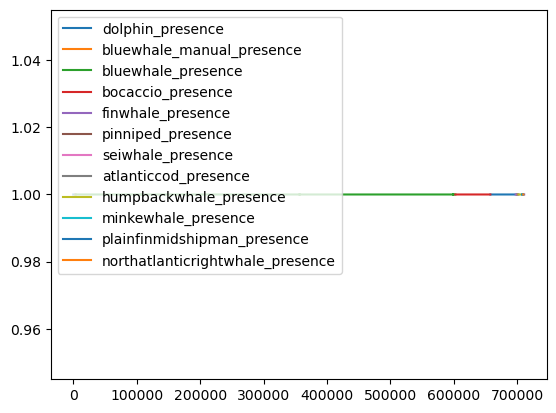

In [12]:
cols = [col for col in df.columns if 'presence' in col]

df[cols].plot()
# TODO check presence vars if they are all 1's.

In [13]:
df.columns

Index(['start_time', 'dolphin_presence', 'end_time', 'dataset_id', 'WKT',
       'decimalLatitude', 'decimalLongitude', 'vernacularName', 'time',
       'bluewhale_manual_presence', 'bluewhale_presence', 'bocaccio_presence',
       'finwhale_effort', 'finwhale_presence', 'pinniped_presence',
       'seiwhale_presence', 'atlanticcod_presence', 'humpbackwhale_presence',
       'minkewhale_presence', 'plainfinmidshipman_presence',
       'northatlanticrightwhale_presence', 'scientificName',
       'scientificNameID', 'taxonRank', 'kingdom'],
      dtype='object')

The `finwhal_effort` column is recording something not consistant with `presence` so let's remove that column.

In [14]:
df.drop(columns=['finwhale_effort'],inplace=True)

df

,start_time,dolphin_presence,end_time,dataset_id,WKT,decimalLatitude,decimalLongitude,vernacularName,time,bluewhale_manual_presence,...,seiwhale_presence,atlanticcod_presence,humpbackwhale_presence,minkewhale_presence,plainfinmidshipman_presence,northatlanticrightwhale_presence,scientificName,scientificNameID,taxonRank,kingdom
0,2018-12-15 04:00:00,1.0,2018-12-15 05:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
1,2018-12-15 05:00:00,1.0,2018-12-15 06:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
2,2018-12-15 06:00:00,1.0,2018-12-15 07:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
3,2018-12-15 07:00:00,1.0,2018-12-15 08:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
4,2018-12-15 18:00:00,1.0,2018-12-15 19:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710817,2020-11-18 00:00:00.000,NaN,2020-11-19 00:00:00.000,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.255080,-70.179047,fin whale,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia
710818,2020-11-19 00:00:00.000,NaN,2020-11-20 00:00:00.000,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.255080,-70.179047,fin whale,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia
710819,2020-11-20 00:00:00.000,NaN,2020-11-21 00:00:00.000,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.255080,-70.179047,fin whale,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia
710820,2020-11-21 00:00:00.000,NaN,2020-11-22 00:00:00.000,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.255080,-70.179047,fin whale,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia


Okay, we have three time variables: 
`start_time`, `end_time`, `time`

We need to make one `eventDate`!

Let's first check to see if we can mash things together.

First, lets print out all the times when `time` has an entry:

In [15]:
df.loc[df['time'].notna(),['start_time','end_time','time']]

,start_time,end_time,time
3447,NaN,NaN,2020-08-08 06:06:30.411000064
3448,NaN,NaN,2020-08-08 06:09:50.621999872
3449,NaN,NaN,2020-08-08 06:11:50.443000064
3450,NaN,NaN,2020-08-08 06:13:55.258000128
3451,NaN,NaN,2020-08-08 06:17:23.515000064
...,...,...,...
602386,NaN,NaN,2020-01-17 10:52:30.664000000
602387,NaN,NaN,2020-01-17 10:55:18.600000256
602388,NaN,NaN,2020-01-17 10:57:06.120000000
602389,NaN,NaN,2020-01-17 10:57:58.344000000


Okay, so let's see if `start_time` is only NaN for all those rows:

In [16]:
df.loc[df['time'].notna(),'start_time'].unique()

array([nan], dtype=object)

Looking good!

Now how about `end_time`? Is it only NaN for all those rows:

In [17]:
df.loc[df['time'].notna(),'end_time'].unique()

array([nan], dtype=object)

Fantastic! So, this means we can make a new column for `eventDate` which merges `time` into `start_time` (or `end_time`?)

In [18]:
df_copy = df.copy()

# start eventDate column with values where `time` exists.
df_copy['eventDate'] = df_copy.loc[df['time'].notna(),['time']]

# fillna with values from start_time
df_copy['eventDate'].fillna(df_copy['start_time'], inplace=True)

df_copy

,start_time,dolphin_presence,end_time,dataset_id,WKT,decimalLatitude,decimalLongitude,vernacularName,time,bluewhale_manual_presence,...,atlanticcod_presence,humpbackwhale_presence,minkewhale_presence,plainfinmidshipman_presence,northatlanticrightwhale_presence,scientificName,scientificNameID,taxonRank,kingdom,eventDate
0,2018-12-15 04:00:00,1.0,2018-12-15 05:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia,2018-12-15 04:00:00
1,2018-12-15 05:00:00,1.0,2018-12-15 06:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia,2018-12-15 05:00:00
2,2018-12-15 06:00:00,1.0,2018-12-15 07:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia,2018-12-15 06:00:00
3,2018-12-15 07:00:00,1.0,2018-12-15 08:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia,2018-12-15 07:00:00
4,2018-12-15 18:00:00,1.0,2018-12-15 19:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia,2018-12-15 18:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710817,2020-11-18 00:00:00.000,NaN,2020-11-19 00:00:00.000,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.255080,-70.179047,fin whale,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia,2020-11-18 00:00:00.000
710818,2020-11-19 00:00:00.000,NaN,2020-11-20 00:00:00.000,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.255080,-70.179047,fin whale,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia,2020-11-19 00:00:00.000
710819,2020-11-20 00:00:00.000,NaN,2020-11-21 00:00:00.000,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.255080,-70.179047,fin whale,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia,2020-11-20 00:00:00.000
710820,2020-11-21 00:00:00.000,NaN,2020-11-22 00:00:00.000,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.255080,-70.179047,fin whale,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia,2020-11-21 00:00:00.000


In [19]:
df_copy.loc[df['time'].isna(),['start_time','eventDate','end_time','time']]

,start_time,eventDate,end_time,time
0,2018-12-15 04:00:00,2018-12-15 04:00:00,2018-12-15 05:00:00,NaN
1,2018-12-15 05:00:00,2018-12-15 05:00:00,2018-12-15 06:00:00,NaN
2,2018-12-15 06:00:00,2018-12-15 06:00:00,2018-12-15 07:00:00,NaN
3,2018-12-15 07:00:00,2018-12-15 07:00:00,2018-12-15 08:00:00,NaN
4,2018-12-15 18:00:00,2018-12-15 18:00:00,2018-12-15 19:00:00,NaN
...,...,...,...,...
710817,2020-11-18 00:00:00.000,2020-11-18 00:00:00.000,2020-11-19 00:00:00.000,NaN
710818,2020-11-19 00:00:00.000,2020-11-19 00:00:00.000,2020-11-20 00:00:00.000,NaN
710819,2020-11-20 00:00:00.000,2020-11-20 00:00:00.000,2020-11-21 00:00:00.000,NaN
710820,2020-11-21 00:00:00.000,2020-11-21 00:00:00.000,2020-11-22 00:00:00.000,NaN


Now, lets make `eventDate` the index for our DataFrame so we can make a nice plot and output the dates in a format we like.

In [20]:
df_copy['eventDate'] = pd.to_datetime(df_copy['eventDate'])
df_copy.set_index('eventDate', inplace=True)

df_copy

,start_time,dolphin_presence,end_time,dataset_id,WKT,decimalLatitude,decimalLongitude,vernacularName,time,bluewhale_manual_presence,...,seiwhale_presence,atlanticcod_presence,humpbackwhale_presence,minkewhale_presence,plainfinmidshipman_presence,northatlanticrightwhale_presence,scientificName,scientificNameID,taxonRank,kingdom
eventDate,,,,,,,,,,,,,,,,,,,,,
2018-12-15 04:00:00,2018-12-15 04:00:00,1.0,2018-12-15 05:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
2018-12-15 05:00:00,2018-12-15 05:00:00,1.0,2018-12-15 06:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
2018-12-15 06:00:00,2018-12-15 06:00:00,1.0,2018-12-15 07:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
2018-12-15 07:00:00,2018-12-15 07:00:00,1.0,2018-12-15 08:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
2018-12-15 18:00:00,2018-12-15 18:00:00,1.0,2018-12-15 19:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-18 00:00:00,2020-11-18 00:00:00.000,NaN,2020-11-19 00:00:00.000,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.255080,-70.179047,fin whale,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia
2020-11-19 00:00:00,2020-11-19 00:00:00.000,NaN,2020-11-20 00:00:00.000,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.255080,-70.179047,fin whale,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia
2020-11-20 00:00:00,2020-11-20 00:00:00.000,NaN,2020-11-21 00:00:00.000,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.255080,-70.179047,fin whale,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia


Let's pull out the presence columns and make a quick plot to see if the values are what we were expecting (value of 1).

<AxesSubplot: xlabel='eventDate'>

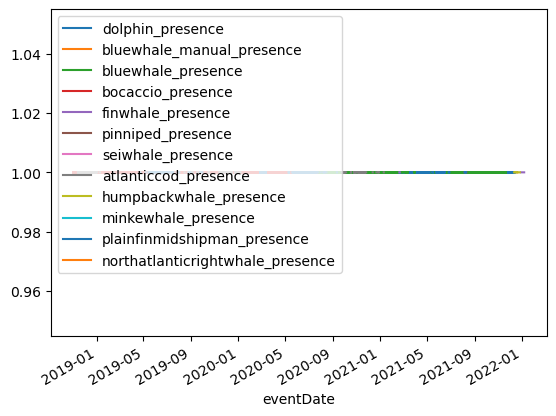

In [21]:
cols = [col for col in df_copy.columns if 'presence' in col]

df_copy[cols].plot()

Let's do some checking to make sure we're doing what we think. Below, we will find where a presence value equals 1, and see if we return a unique `scientificNameID`.

In [22]:
for column in cols:
    if len(df_copy.loc[df_copy[column]==1,'scientificNameID'].unique()) != 1:
        print('{} != 1'.format(column))
    else:
        print('{} is good!'.format(column))

dolphin_presence is good!
bluewhale_manual_presence is good!
bluewhale_presence is good!
bocaccio_presence is good!
finwhale_presence is good!
pinniped_presence is good!
seiwhale_presence is good!
atlanticcod_presence is good!
humpbackwhale_presence is good!
minkewhale_presence is good!
plainfinmidshipman_presence is good!
northatlanticrightwhale_presence is good!


Now, let's make sure we don't have any NaN rows for the presence columns:

In [23]:
df[cols].isna().any(axis=1).unique()

array([ True])

Now, that we know we are representing the precenses appropriately. Let's remove the presence columns. That information will be documented via the species information.

In [24]:
occur = df_copy.drop(columns=cols)

occur

,start_time,end_time,dataset_id,WKT,decimalLatitude,decimalLongitude,vernacularName,time,scientificName,scientificNameID,taxonRank,kingdom
eventDate,,,,,,,,,,,,
2018-12-15 04:00:00,2018-12-15 04:00:00,2018-12-15 05:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
2018-12-15 05:00:00,2018-12-15 05:00:00,2018-12-15 06:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
2018-12-15 06:00:00,2018-12-15 06:00:00,2018-12-15 07:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
2018-12-15 07:00:00,2018-12-15 07:00:00,2018-12-15 08:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
2018-12-15 18:00:00,2018-12-15 18:00:00,2018-12-15 19:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-18 00:00:00,2020-11-18 00:00:00.000,2020-11-19 00:00:00.000,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.255080,-70.179047,fin whale,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia
2020-11-19 00:00:00,2020-11-19 00:00:00.000,2020-11-20 00:00:00.000,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.255080,-70.179047,fin whale,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia
2020-11-20 00:00:00,2020-11-20 00:00:00.000,2020-11-21 00:00:00.000,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.255080,-70.179047,fin whale,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia


Let's write it out as an occurrence file.

In [25]:
occur.to_csv('data/occurrence.csv')

Let's read it back in to do some fiddling.

In [26]:
import pandas as pd

pd.read_csv('data/occurrence.csv')

C:\Users\Mathew.Biddle\AppData\Local\Temp\3\ipykernel_12164\26960631.py:3: DtypeWarning: Columns (1,2,8) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('data/occurrence.csv')


,eventDate,start_time,end_time,dataset_id,WKT,decimalLatitude,decimalLongitude,vernacularName,time,scientificName,scientificNameID,taxonRank,kingdom
0,2018-12-15 04:00:00.000000000,2018-12-15 04:00:00,2018-12-15 05:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
1,2018-12-15 05:00:00.000000000,2018-12-15 05:00:00,2018-12-15 06:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
2,2018-12-15 06:00:00.000000000,2018-12-15 06:00:00,2018-12-15 07:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
3,2018-12-15 07:00:00.000000000,2018-12-15 07:00:00,2018-12-15 08:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
4,2018-12-15 18:00:00.000000000,2018-12-15 18:00:00,2018-12-15 19:00:00,noaaSanctSound_GR01_01_dolphins_1h,POINT (31.396417 -80.8904),31.396417,-80.890400,dolphin,NaN,Cetacea,urn:lsid:marinespecies.org:taxname:2688,Infraorder,Animalia
...,...,...,...,...,...,...,...,...,...,...,...,...,...
710817,2020-11-18 00:00:00.000,2020-11-18 00:00:00.000,2020-11-19 00:00:00.000,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.255080,-70.179047,fin whale,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia
710818,2020-11-19 00:00:00.000,2020-11-19 00:00:00.000,2020-11-20 00:00:00.000,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.255080,-70.179047,fin whale,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia
710819,2020-11-20 00:00:00.000,2020-11-20 00:00:00.000,2020-11-21 00:00:00.000,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.255080,-70.179047,fin whale,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia
710820,2020-11-21 00:00:00.000,2020-11-21 00:00:00.000,2020-11-22 00:00:00.000,noaaSanctSound_SB03_12_finwhale_1d,POINT (42.25508 -70.179047),42.255080,-70.179047,fin whale,NaN,Balaenoptera physalus,urn:lsid:marinespecies.org:taxname:137091,Species,Animalia


In [27]:
import humanize
import os

humanize.naturalsize(os.path.getsize('data/occurrence.csv'))

'167.7 MB'

In [28]:
humanize.naturalsize(os.path.getsize('data/sanctsound_presence.csv'))

'158.1 MB'